## PPO with Clipped Objective

- PPO strikes a balance between ease of implementation, sample complexity, and ease of tuning, trying to compute an update at each step that minimizes the cost function while ensuring the deviation from the previous policy is relatively small.

<center>*source : https://openai.com/blog/openai-baselines-ppo/  </center>

***

<img src=attachment:image.png width=600><br>
<center>*source: Advanced Policy Gradient Methods, John Schulman</center>
- $L^{PG}$ empirically often leads to destructively large policy updates.
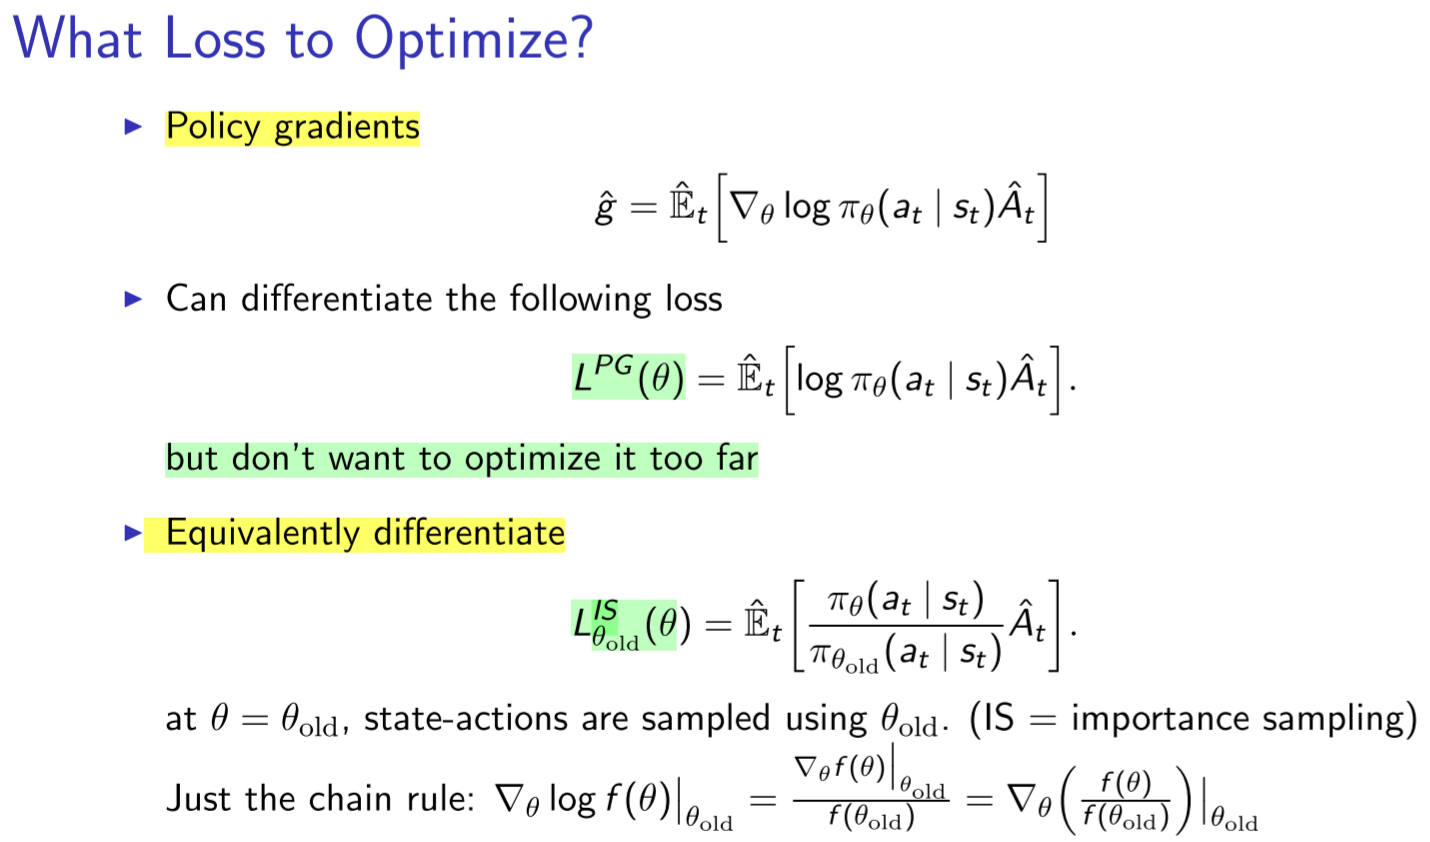

<img src=attachment:image.png width=500><br>
<center>*source: Advanced Policy Gradient Methods, John Schulman</center>
- TRPO tries to maximize the original objective with the KL constraint (update only in the 'trust region'). <br>
- To solve it, we can use Taylor’s series to expand both terms above up to the second-order. But the second-order of $L$ is much smaller than the KL-divergence term and will be ignored.<br>
- Now we can analytically solve the second-order approximate equation, an the solution for the $\Delta\theta$ is the natural gradient, $H^{-1}g$. <br>
- In TRPO, they use Conjugate Gradient so that the Fisher Information Matrix does not need to be explicitly computed, but still TRPO is very complicated to implement.
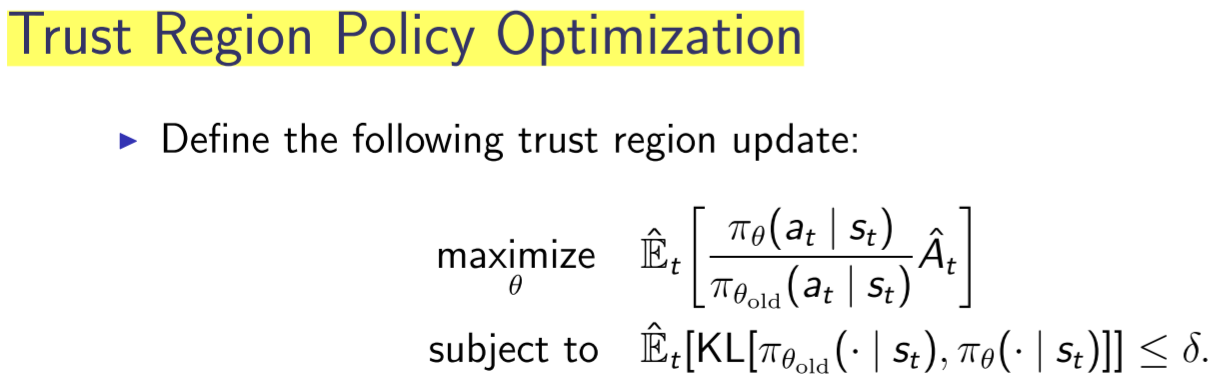

***
**Proximal Policy Optimization with Clipped Objective**
<p>\[L^{CLIP}(\theta) = \hat{E}_{t}[ min( r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1 - \varepsilon, 1 + \varepsilon) \hat{A}_t ) ]\]</p>
<ul>
<li>$r_t(\theta)=\dfrac{\pi_\theta(a_t|s_t)}{\pi_{\theta old}(a_t|s_t)}, \, \, r_t(\theta old) = 1$</li>
    - $\pi_\theta(a_t|s_t)$: we maintain two policy networks. The first one is the current policy that we want to refine. <br>
    - $\pi_{\theta old}(a_t|s_t)$: The second is the policy that we last used to collect samples.
<li>\(\hat{A}_t\)is the estimated advantage at time \(t\)</li>
<li>\(\varepsilon\) is a hyperparameter, usually 0.1 or 0.2</li>


In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:1")

In [2]:
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

In [3]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.actor = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),            
        )
        self.critic = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def act(self, x, softmax_dim=0):
        return F.softmax(self.actor(x), dim=softmax_dim)

    def evaluate(self, x):
        return self.critic(x)
    
    def forward(self, x, softmax_dim=0):
        return F.softmax(self.actor(x), dim=softmax_dim), self.critic(x)

In [4]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.actor_critic = ActorCritic().to(device)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
        
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, device=device, dtype=torch.float), torch.tensor(a_lst, device=device), \
                                          torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, device=device, dtype=torch.float), \
                                          torch.tensor(done_lst, device=device, dtype=torch.float), torch.tensor(prob_a_lst, device=device)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.actor_critic.evaluate(s_prime) * done_mask
            delta = td_target - self.actor_critic.evaluate(s)
            delta = delta.detach().cpu().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, device=device,  dtype=torch.float)

            pi, val = self.actor_critic(s, softmax_dim=1)
            
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(val, td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [5]:
env = gym.make('CartPole-v1')
model = PPO().to(device)
score = 0.0
print_interval = 100

In [6]:
s = env.reset()
t= torch.tensor(s, device=device, dtype=torch.float32)
print(t)

tensor([-0.0012,  0.0159,  0.0155, -0.0361], device='cuda:1')


In [7]:
for n_epi in range(1000):
    s = env.reset()
    done = False
    while not done:
        for t in range(T_horizon):
            
            prob = model.actor_critic.act(torch.tensor(s, device=device, dtype=torch.float32))
            
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            model.put_data((s, a, r/100, s_prime, prob[a].item(), done))
            s = s_prime
                
            score += r
            if done:
                break

        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

env.close()

episode :100, avg score : 92.9
episode :200, avg score : 257.0
episode :300, avg score : 273.7
episode :400, avg score : 269.3
episode :500, avg score : 365.5
episode :600, avg score : 342.5
episode :700, avg score : 265.4
episode :800, avg score : 311.4
episode :900, avg score : 433.1
